In [ ]:
!pip install dlib
!pip install opencv-python-headless
!pip install scikit-image



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import yaml
from collections import defaultdict
from PIL import Image

import seaborn as sns
import dlib
from skimage import feature
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# 1. Dataset Summary


In [ ]:
# Load the data.yaml file
with open("/content/drive/My Drive/ColabNotebooks/Facial Feature Extraction Dataset/data.yaml", 'r') as file:
    data_config = yaml.safe_load(file)

# Display the contents of the YAML file
print(data_config)


{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 5, 'names': ['eye', 'eyebrow', 'lip', 'mustache-beard', 'nose'], 'roboflow': {'workspace': 'kagna-technologies-ddmoj', 'project': 'extracting-facial-features', 'version': 1, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/kagna-technologies-ddmoj/extracting-facial-features/dataset/1'}}


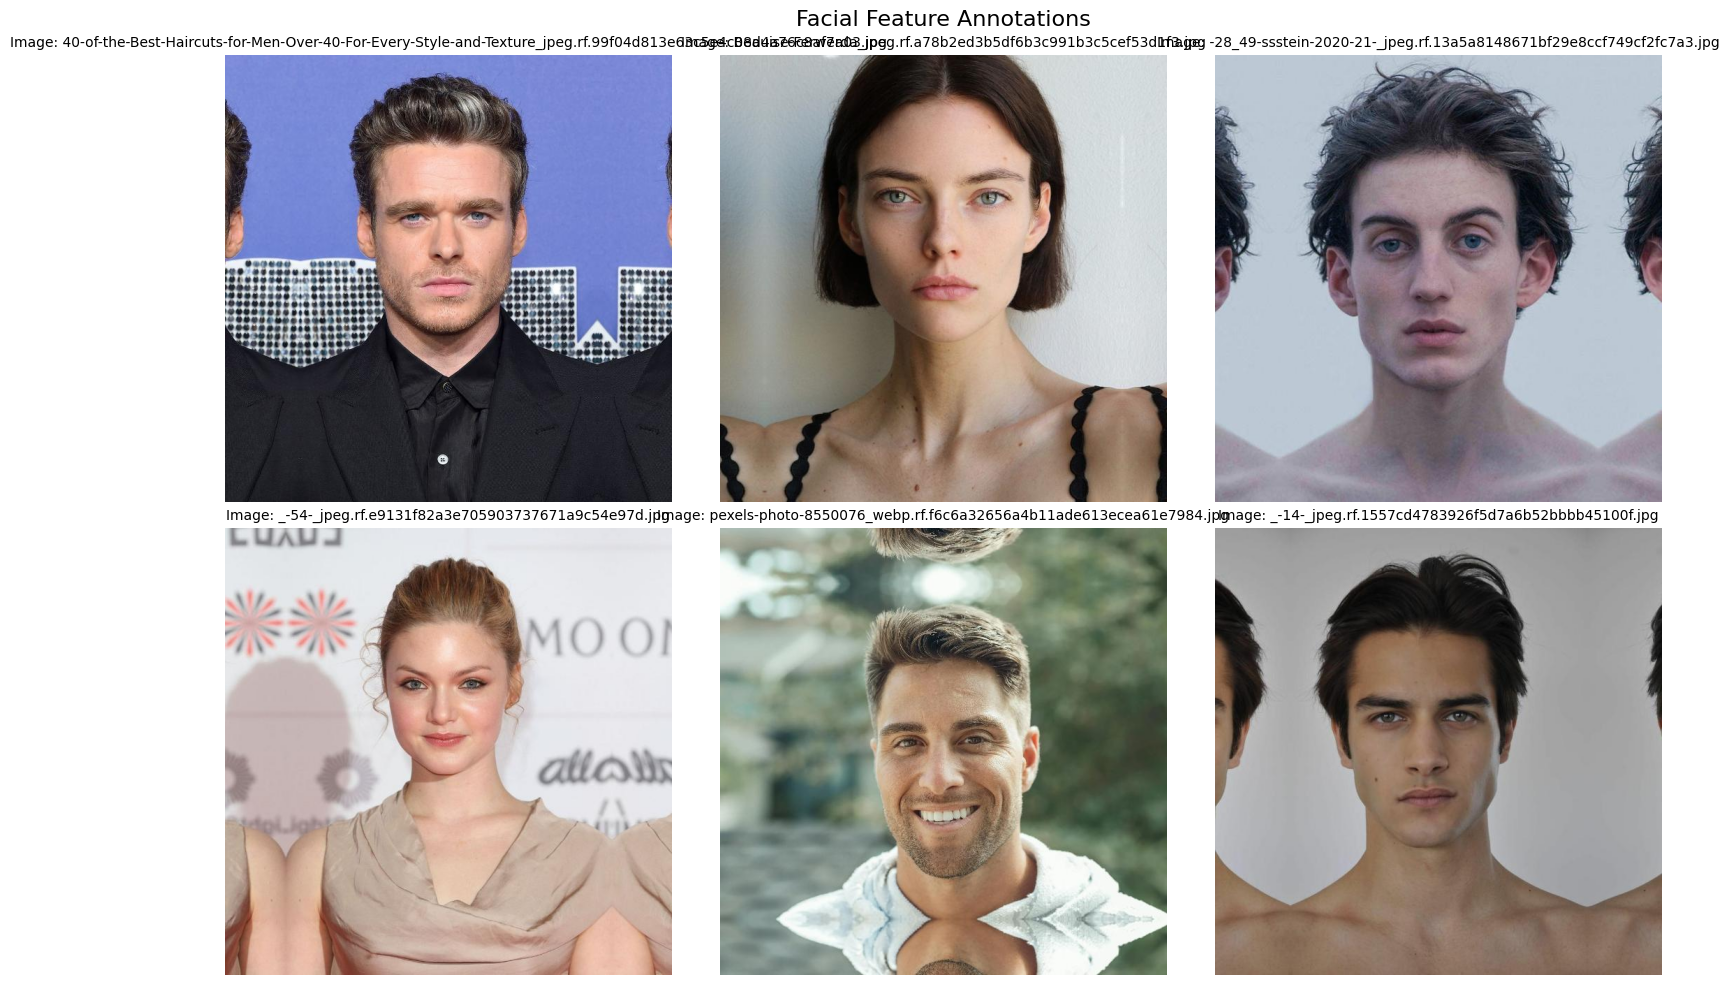

In [ ]:

# Load the dataset
base_path = "/content/drive/My Drive/ColabNotebooks/Facial Feature Extraction Dataset"


train_images_path = os.path.join(base_path, 'train', 'images')
train_labels_path = os.path.join(base_path, 'train', 'labels')
test_images_path = os.path.join(base_path, 'test', 'images')
test_labels_path = os.path.join(base_path, 'test', 'labels')
valid_images_path = os.path.join(base_path, 'valid', 'images')
valid_labels_path = os.path.join(base_path, 'valid', 'labels')



##Sample Data

In [ ]:
def analyze_directory(split_name):
   split_path = os.path.join(base_path, split_name)
   print(f"\n=== {split_name.upper()} Directory Analysis ===")

   if os.path.exists(split_path):
       # Images analysis
       images_path = os.path.join(split_path, 'images')
       if os.path.exists(images_path):
           images = os.listdir(images_path)
           print(f"\nTop 5 Images from {split_name}/images:")
           print(images[:5])
           print(f"Total number of images: {len(images)}")
       else:
           print(f"No images directory found in {split_name}")

       # Labels analysis
       labels_path = os.path.join(split_path, 'labels')
       if os.path.exists(labels_path):
           labels = os.listdir(labels_path)
           print(f"\nTop 5 Labels from {split_name}/labels:")
           print(labels[:5])
           print(f"Total number of labels: {len(labels)}")

           # Sample label content
           if labels:
               print(f"\nSample content of first label file in {split_name}:")
               try:
                   with open(os.path.join(labels_path, labels[0]), 'r') as f:
                       print(f"Content of {labels[0]}:")
                       print(f.read().strip())
               except Exception as e:
                   print(f"Error reading label file: {e}")
       else:
           print(f"No labels directory found in {split_name}")
   else:
       print(f"Directory not found: {split_path}")

# Analyze each split
analyze_directory('train')
#analyze_directory('valid')
#analyze_directory('test')


=== TRAIN Directory Analysis ===

Top 5 Images from train/images:
['40-of-the-Best-Haircuts-for-Men-Over-40-For-Every-Style-and-Texture_jpeg.rf.99f04d813e63c5e4c08d4a76c8af7a03.jpg', 'Beauise-Ferwerda_jpeg.rf.a78b2ed3b5df6b3c991b3c5cef53d1f3.jpg', '-28_49-ssstein-2020-21-_jpeg.rf.13a5a8148671bf29e8ccf749cf2fc7a3.jpg', '_-54-_jpeg.rf.e9131f82a3e705903737671a9c54e97d.jpg', 'pexels-photo-8550076_webp.rf.f6c6a32656a4b11ade613ecea61e7984.jpg']
Total number of images: 457

Top 5 Labels from train/labels:
['_-10-_jpeg.rf.b8b8e134fbe8ded08246968bcfe42f37.txt', '_-9-_jpeg.rf.98e7477d98c610002f61855edb44a2ac.txt', 'TABIOLO-HEADSHOTS-MAIN-PAGE-Headshot-Photography-by-Brandon-Tabiolo-2-_jpeg.rf.3af3376ab099d923865585a3f4027f6b.txt', '_-24-_jpeg.rf.a4b0cc407298be717c8635dc5dff55cc.txt', 'Adrien-Jacques_jpeg.rf.e2c53936d65c57e7a4b07c206d58bc04.txt']
Total number of labels: 457

Sample content of first label file in train:
Content of _-10-_jpeg.rf.b8b8e134fbe8ded08246968bcfe42f37.txt:
1 0.4984375 0.

##Sample Image

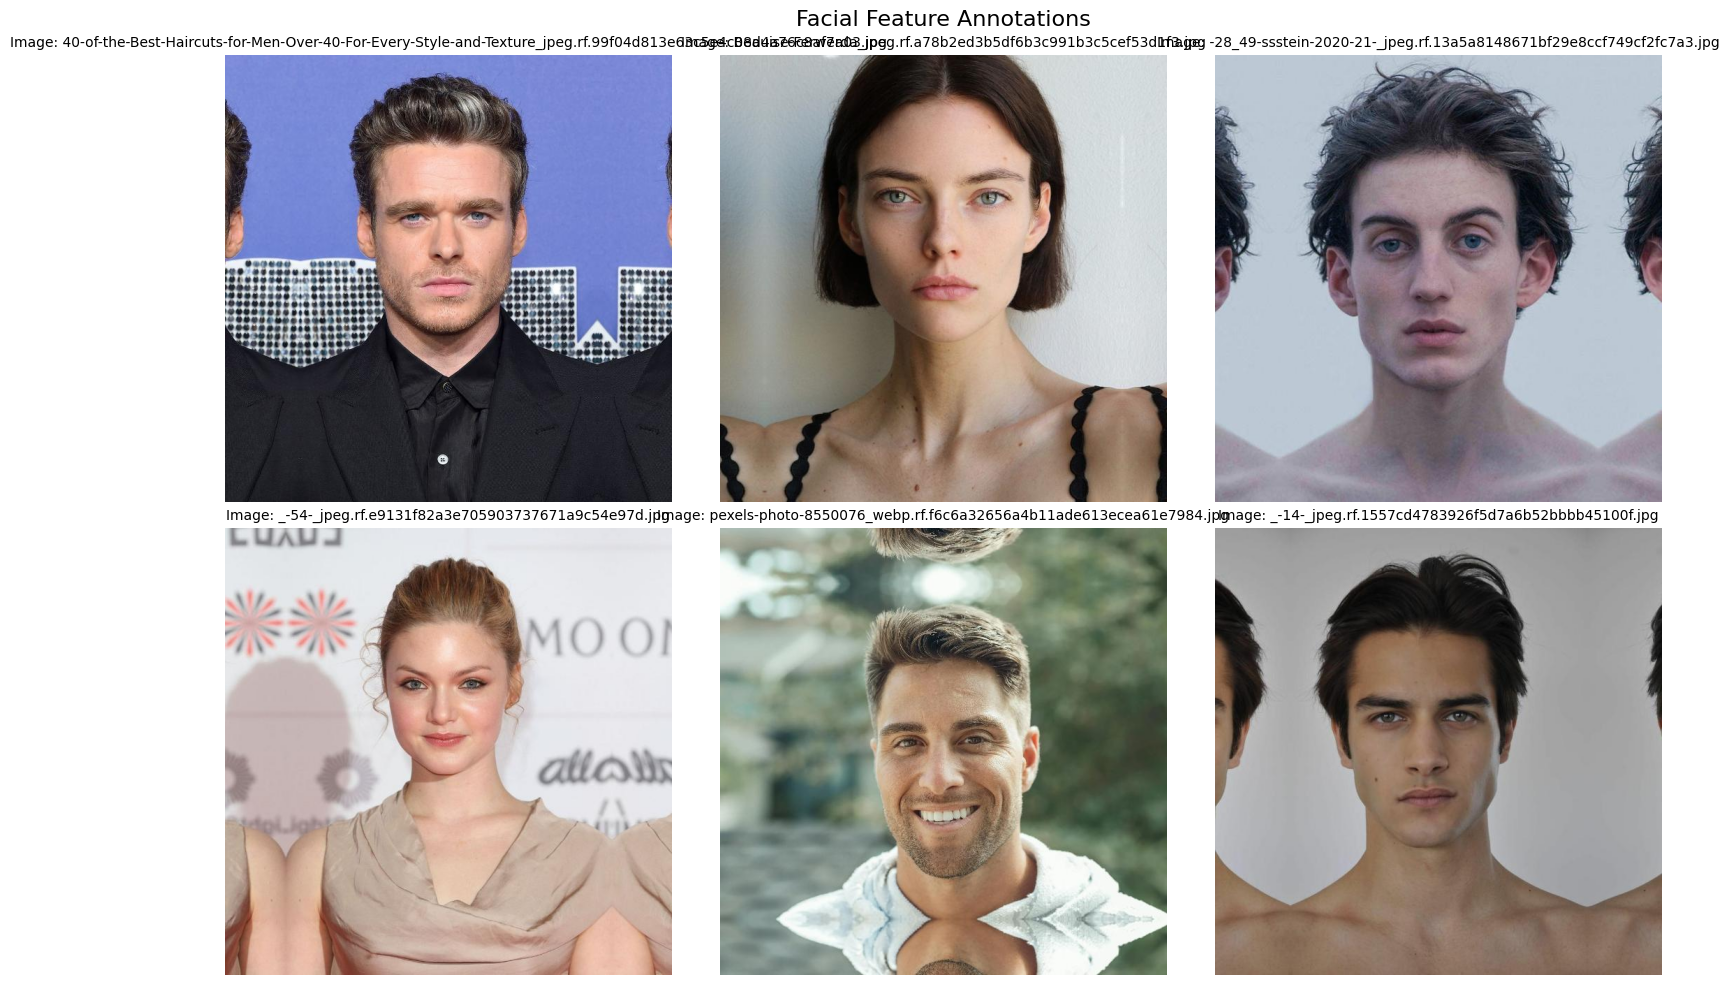

In [ ]:


class_names = ['eye', 'eyebrow', 'lip', 'mustache-beard', 'nose']


# List the first few images and labels
train_images = os.listdir(train_images_path)[:6]
train_labels = os.listdir(train_labels_path)[:6]

# Create a 2x3 grid for visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns
fig.suptitle('Facial Feature Annotations', fontsize=16)

# Iterate through the first 6 images and labels
for i, (img_name, label_name) in enumerate(zip(train_images, train_labels)):
    img_path = os.path.join(train_images_path, img_name)
    label_path = os.path.join(train_labels_path, label_name)

    # Load the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

    # Plot the image in the grid
    row = i // 3  # Determine the row (0 or 1)
    col = i % 3   # Determine the column (0, 1, or 2)
    ax = axes[row, col]
    ax.imshow(img)
    ax.set_title(f"Image: {img_name}", fontsize=10)
    ax.axis('off')  # Hide axes for better visualization

plt.tight_layout()
plt.show()

#Total Image count

In [ ]:

print(f"Train Images: {len(os.listdir(train_images_path))}, Train Labels: {len(os.listdir(train_labels_path))}")
print(f"Test Images: {len(os.listdir(test_images_path))}, Test Labels: {len(os.listdir(test_labels_path))}")
print(f"Validation Images: {len(os.listdir(valid_images_path))}, Validation Labels: {len(os.listdir(valid_labels_path))}")

Train Images: 457, Train Labels: 457
Test Images: 66, Test Labels: 66
Validation Images: 126, Validation Labels: 126


In [ ]:

def analyze_few_samples(split_path, num_samples=5):
    """Analyze just a few samples from the dataset"""
    images_path = os.path.join(split_path, 'images')
    labels_path = os.path.join(split_path, 'labels')

    # Initialize dlib's face detector
    detector = dlib.get_frontal_face_detector()

    image_data = []
    for img_name in os.listdir(images_path)[:num_samples]:  # Only process first few images
        img_path = os.path.join(images_path, img_name)
        try:
            img = cv2.imread(img_path)
            if img is not None:
                height, width, channels = img.shape
                size = os.path.getsize(img_path) / 1024

                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                faces = detector(gray)

                brightness = np.mean(gray)
                contrast = np.std(gray)
                edges = feature.canny(gray)
                edge_density = np.mean(edges)

                data = {
                    'filename': img_name,
                    'width': width,
                    'height': height,
                    'channels': channels,
                    'size_kb': size,
                    'faces_detected': len(faces),
                    'brightness': brightness,
                    'contrast': contrast,
                    'edge_density': edge_density,
                    'aspect_ratio': width/height
                }

                image_data.append(data)

        except Exception as e:
            print(f"Error processing {img_name}: {str(e)}")

    return pd.DataFrame(image_data)

def main():
    splits = ['train', 'valid', 'test']

    for split in splits:
        split_path = os.path.join(base_path, split)
        if os.path.exists(split_path):
            print(f"\n=== {split.upper()} Dataset Sample Analysis ===")

            # Show sample images and their labels
            show_sample_images(split_path, num_samples=5)

            # Analyze few samples
            df = analyze_few_samples(split_path, num_samples=5)

            if not df.empty:
                print("\nSample Data Info:")
                print(df.info())

                print("\nSample Data Head:")
                print(df.head())

                print("\nBasic Statistics for Samples:")
                print(df.describe())

                print("\nNull Values in Samples:")
                print(df.isnull().sum())

                # Simple visualization for the samples
                plt.figure(figsize=(15, 5))

                # 1. Image Dimensions
                plt.subplot(1, 3, 1)
                plt.scatter(df['width'], df['height'])
                plt.title(f'{split} - Sample Image Dimensions')
                plt.xlabel('Width')
                plt.ylabel('Height')

                # 2. Brightness Distribution
                plt.subplot(1, 3, 2)
                plt.hist(df['brightness'], bins=10)
                plt.title(f'{split} - Sample Brightness Distribution')

                # 3. Face Detection Results
                plt.subplot(1, 3, 3)
                plt.bar(['Faces Detected'], [df['faces_detected'].mean()])
                plt.title(f'{split} - Avg Faces per Image')

                plt.tight_layout()
                plt.show()

                print("\nImage Quality Metrics for Samples:")
                print(f"Average brightness: {df['brightness'].mean():.2f}")
                print(f"Average contrast: {df['contrast'].mean():.2f}")
                print(f"Average edge density: {df['edge_density'].mean():.2f}")
                print(f"Face detection rate: {(df['faces_detected'] > 0).mean():.2%}")
            else:
                print(f"No images found in {split} directory")

if __name__ == "__main__":
    main()


=== TRAIN Dataset Sample Analysis ===

Basic Statistics for Samples:
       width  height  channels    size_kb  faces_detected  brightness  \
count    5.0     5.0       5.0   5.000000             5.0    5.000000   
mean   640.0   640.0       3.0  42.774609             1.0  143.726998   
std      0.0     0.0       0.0   9.904306             0.0   31.615588   
min    640.0   640.0       3.0  34.679688             1.0  101.049094   
25%    640.0   640.0       3.0  37.208984             1.0  139.348723   
50%    640.0   640.0       3.0  38.311523             1.0  141.858254   
75%    640.0   640.0       3.0  44.362305             1.0  146.311470   
max    640.0   640.0       3.0  59.310547             1.0  190.067446   

        contrast  edge_density  aspect_ratio  
count   5.000000      5.000000           5.0  
mean   53.916820      0.051908           1.0  
std     9.089073      0.016434           0.0  
min    39.622976      0.027805           1.0  
25%    51.331310      0.049001       

<Figure size 1500x500 with 0 Axes>

# 2. Class Distribution Analysis


In [ ]:


# Function to count labels
def count_labels(labels_path):
    label_counts = defaultdict(int)
    for label_file in os.listdir(labels_path):
        with open(os.path.join(labels_path, label_file), 'r') as f:
            for line in f:
                label = line.strip().split()[0]  # Assuming the first value is the class label
                label_counts[label] += 1
    return label_counts

# Get label counts for train, test, and validation
train_label_counts = count_labels(train_labels_path)
test_label_counts = count_labels(test_labels_path)
valid_label_counts = count_labels(valid_labels_path)

<ipython-input-14-a450e2669e4a>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=counts, palette='viridis', ax=axes[0])
<ipython-input-14-a450e2669e4a>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=counts, palette='viridis', ax=axes[1])
<ipython-input-14-a450e2669e4a>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=counts, palette='viridis', ax=axes[2])


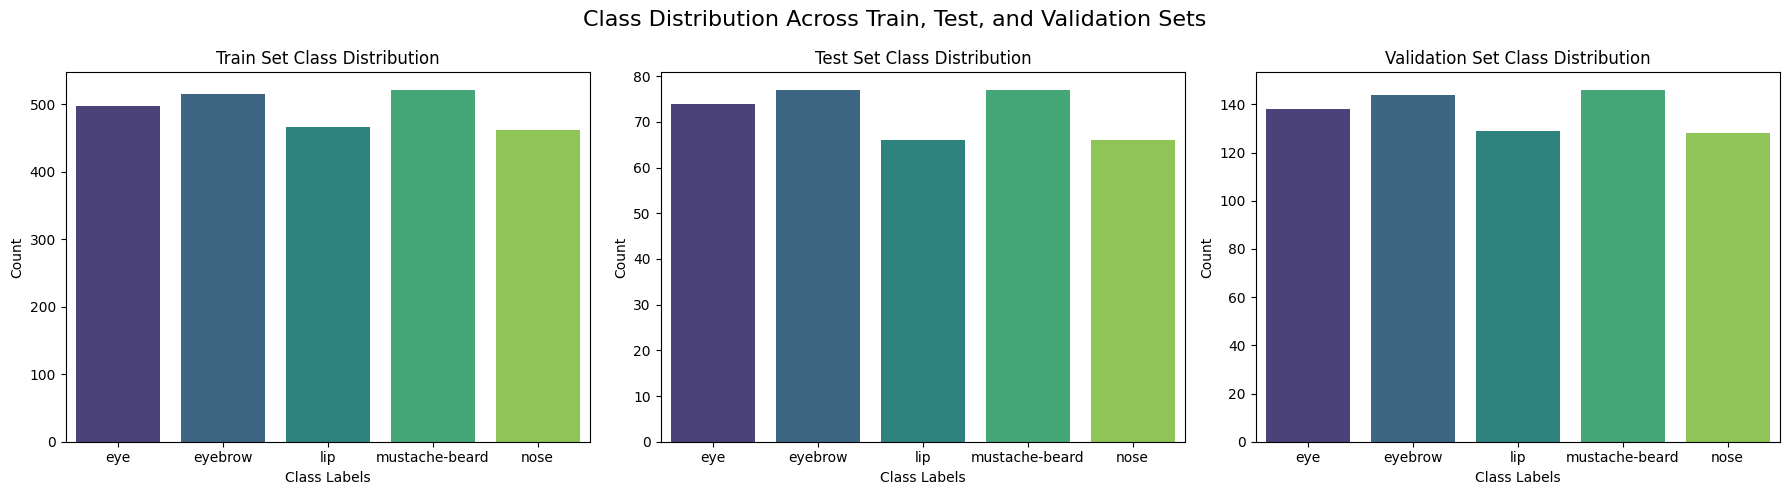

In [ ]:
# Function to plot class distribution in a single row
def plot_class_distribution_in_row(train_counts, test_counts, valid_counts, class_names):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns
    fig.suptitle('Class Distribution Across Train, Test, and Validation Sets', fontsize=16)

    # Ensure all class labels (0 to 4) are present in the counts
    for counts in [train_counts, test_counts, valid_counts]:
        for class_id in range(len(class_names)):
            if str(class_id) not in counts:
                counts[str(class_id)] = 0  # Add missing class with count 0

    # Plot train set distribution
    labels = [str(i) for i in range(len(class_names))]  # Labels as strings (0 to 4)
    counts = [train_counts[label] for label in labels]
    sns.barplot(x=class_names, y=counts, palette='viridis', ax=axes[0])
    axes[0].set_title('Train Set Class Distribution')
    axes[0].set_xlabel('Class Labels')
    axes[0].set_ylabel('Count')

    # Plot test set distribution
    counts = [test_counts[label] for label in labels]
    sns.barplot(x=class_names, y=counts, palette='viridis', ax=axes[1])
    axes[1].set_title('Test Set Class Distribution')
    axes[1].set_xlabel('Class Labels')
    axes[1].set_ylabel('Count')

    # Plot validation set distribution
    counts = [valid_counts[label] for label in labels]
    sns.barplot(x=class_names, y=counts, palette='viridis', ax=axes[2])
    axes[2].set_title('Validation Set Class Distribution')
    axes[2].set_xlabel('Class Labels')
    axes[2].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

# Plot class distributions in a single row
plot_class_distribution_in_row(train_label_counts, test_label_counts, valid_label_counts, class_names)

# 3. Image Dimension Distribution

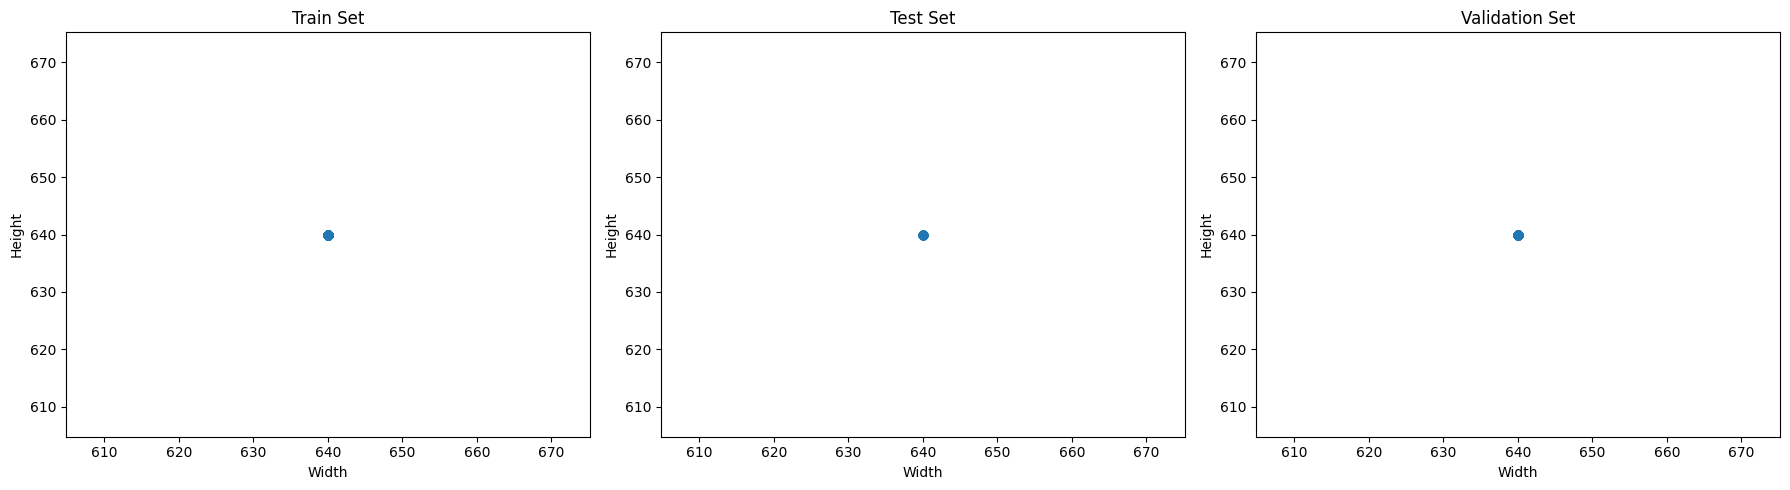

In [ ]:
# Function to get image dimensions
def get_image_dimensions(images_path):
    dimensions = []
    for img_file in os.listdir(images_path):
        img = Image.open(os.path.join(images_path, img_file))
        dimensions.append(img.size)
    return dimensions

# Get dimensions
train_dimensions = get_image_dimensions(train_images_path)
test_dimensions = get_image_dimensions(test_images_path)
valid_dimensions = get_image_dimensions(valid_images_path)
# Function to plot image dimensions in a row
def plot_dimensions_row(train_dims, test_dims, valid_dims):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Create a row of 3 subplots

    datasets = [("Train Set", train_dims), ("Test Set", test_dims), ("Validation Set", valid_dims)]

    for ax, (title, dims) in zip(axes, datasets):
        widths, heights = zip(*dims)
        ax.scatter(widths, heights, alpha=0.5)
        ax.set_title(title)
        ax.set_xlabel("Width")
        ax.set_ylabel("Height")

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()

# Plot dimensions in a row
plot_dimensions_row(train_dimensions, test_dimensions, valid_dimensions)


# 4. Bounding Box Distribution


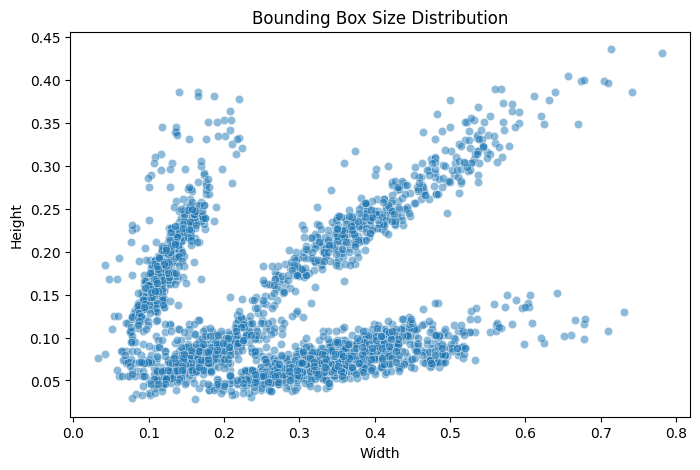

In [ ]:
# Extract bounding box sizes
def get_bounding_box_sizes(labels_path):
    bbox_sizes = []
    for label_file in os.listdir(labels_path):
        with open(os.path.join(labels_path, label_file), 'r') as f:
            for line in f:
                _, _, _, width, height = map(float, line.strip().split())
                bbox_sizes.append((width, height))
    return bbox_sizes

train_bbox_sizes = get_bounding_box_sizes(train_labels_path)

# Plot bounding box sizes
bbox_widths, bbox_heights = zip(*train_bbox_sizes)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=bbox_widths, y=bbox_heights, alpha=0.5)
plt.title('Bounding Box Size Distribution')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()


In [ ]:

# Check image dimensions and color channels
for img_name in train_images:
    img_path = os.path.join(train_images_path, img_name)
    img = Image.open(img_path)
    print(f"Image: {img_name}, Size: {img.size}, Mode: {img.mode}")

Image: 40-of-the-Best-Haircuts-for-Men-Over-40-For-Every-Style-and-Texture_jpeg.rf.99f04d813e63c5e4c08d4a76c8af7a03.jpg, Size: (640, 640), Mode: RGB
Image: Beauise-Ferwerda_jpeg.rf.a78b2ed3b5df6b3c991b3c5cef53d1f3.jpg, Size: (640, 640), Mode: RGB
Image: -28_49-ssstein-2020-21-_jpeg.rf.13a5a8148671bf29e8ccf749cf2fc7a3.jpg, Size: (640, 640), Mode: RGB
Image: _-54-_jpeg.rf.e9131f82a3e705903737671a9c54e97d.jpg, Size: (640, 640), Mode: RGB
Image: pexels-photo-8550076_webp.rf.f6c6a32656a4b11ade613ecea61e7984.jpg, Size: (640, 640), Mode: RGB


# 5. Color Distributon:  RGB or Grayscale

In [ ]:


# Function to check color distribution
def check_image_color_distribution(images_path, sample_size=100):
    color_counts = {"RGB": 0, "Grayscale": 0}
    image_files = os.listdir(images_path)[:sample_size]  # Sample images

    for img_file in image_files:
        img = cv2.imread(os.path.join(images_path, img_file))  # Read image
        if len(img.shape) == 3 and img.shape[2] == 3:
            color_counts["RGB"] += 1
        else:
            color_counts["Grayscale"] += 1

    return color_counts

# Compute color distributions
train_color_dist = check_image_color_distribution(train_images_path)
test_color_dist = check_image_color_distribution(test_images_path)
valid_color_dist = check_image_color_distribution(valid_images_path)

# Display results
print(f"Train Set: {train_color_dist}")
print(f"Test Set: {test_color_dist}")
print(f"Validation Set: {valid_color_dist}")


Train Set: {'RGB': 100, 'Grayscale': 0}
Test Set: {'RGB': 66, 'Grayscale': 0}
Validation Set: {'RGB': 100, 'Grayscale': 0}


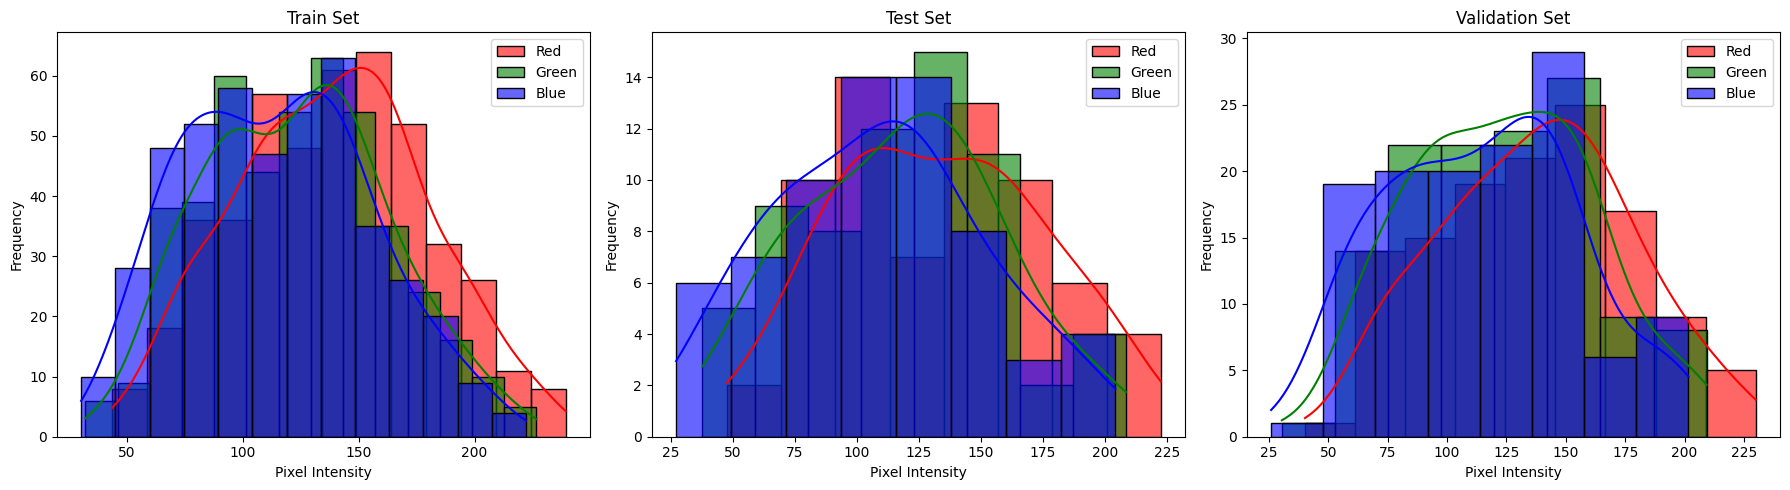

In [ ]:

# Function to compute mean color values for each image
def get_mean_colors(images_path):
    mean_colors = {"Red": [], "Green": [], "Blue": []}

    for img_file in os.listdir(images_path):
        img = cv2.imread(os.path.join(images_path, img_file))  # Read image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        mean_r, mean_g, mean_b = np.mean(img[:, :, 0]), np.mean(img[:, :, 1]), np.mean(img[:, :, 2])

        mean_colors["Red"].append(mean_r)
        mean_colors["Green"].append(mean_g)
        mean_colors["Blue"].append(mean_b)

    return mean_colors

# Compute color distributions
train_colors = get_mean_colors(train_images_path)
test_colors = get_mean_colors(test_images_path)
valid_colors = get_mean_colors(valid_images_path)

# Function to plot RGB color distribution
def plot_color_distribution(train_colors, test_colors, valid_colors):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Create subplots

    datasets = [("Train Set", train_colors), ("Test Set", test_colors), ("Validation Set", valid_colors)]

    for ax, (title, colors) in zip(axes, datasets):
        sns.histplot(colors["Red"], color="red", label="Red", kde=True, alpha=0.6, ax=ax)
        sns.histplot(colors["Green"], color="green", label="Green", kde=True, alpha=0.6, ax=ax)
        sns.histplot(colors["Blue"], color="blue", label="Blue", kde=True, alpha=0.6, ax=ax)

        ax.set_title(title)
        ax.set_xlabel("Pixel Intensity")
        ax.set_ylabel("Frequency")
        ax.legend()

    plt.tight_layout()
    plt.show()

# Plot color distributions
plot_color_distribution(train_colors, test_colors, valid_colors)


# 6. Exploring Bounding Box Positions


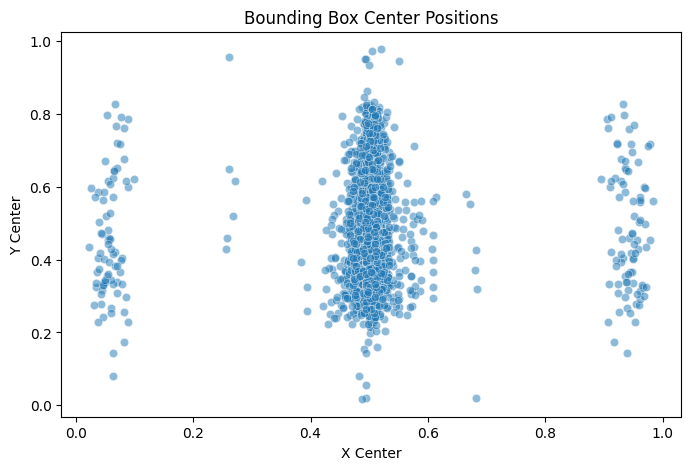

In [ ]:
def get_bbox_positions(labels_path):
    bbox_positions = []
    for label_file in os.listdir(labels_path):
        with open(os.path.join(labels_path, label_file), 'r') as f:
            for line in f:
                _, x_center, y_center, _, _ = map(float, line.strip().split())
                bbox_positions.append((x_center, y_center))
    return bbox_positions

train_bbox_positions = get_bbox_positions(train_labels_path)

# Plot bounding box positions
bbox_x, bbox_y = zip(*train_bbox_positions)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=bbox_x, y=bbox_y, alpha=0.5)
plt.title('Bounding Box Center Positions')
plt.xlabel('X Center')
plt.ylabel('Y Center')
plt.show()

# 7. Sample Image Annotations


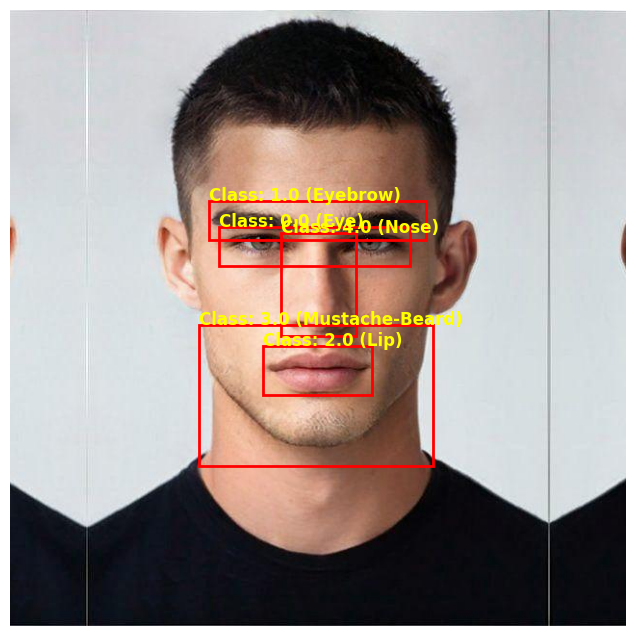

In [ ]:
# Define class names
class_names = {0: "Eye", 1: "Eyebrow", 2: "Lip", 3: "Mustache-Beard", 4: "Nose"}

def plot_sample_annotations(image_path, label_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    with open(label_path, 'r') as file:
        annotations = file.readlines()

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    ax = plt.gca()

    for ann in annotations:
        class_id, x_center, y_center, width, height = map(float, ann.strip().split())
        x_center *= w
        y_center *= h
        width *= w
        height *= h
        x_min = x_center - width / 2
        y_min = y_center - height / 2

        rect = plt.Rectangle((x_min, y_min), width, height, edgecolor='red', facecolor='none', linewidth=2)
        ax.add_patch(rect)

        # Get class name
        class_name = class_names.get(int(class_id), "Unknown")
        plt.text(x_min, y_min, f'Class: {class_id} ({class_name})', color='yellow', fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()

# Example usage
plot_sample_annotations(train_images_path + "/__jpeg.rf.83725ed6bedc39d3a3cd85029caf91ef.jpg",
                        train_labels_path + "/__jpeg.rf.83725ed6bedc39d3a3cd85029caf91ef.txt")


# 7. Feature Correlation Analysis


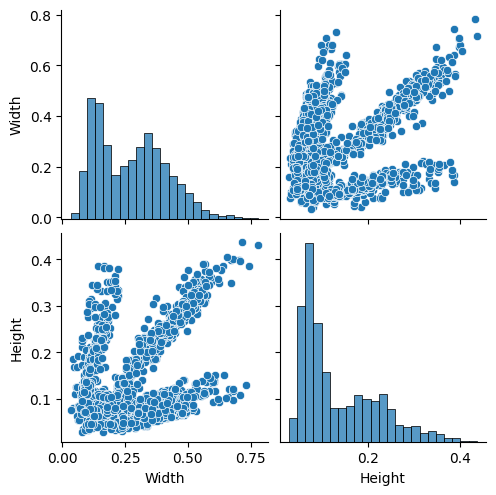

In [ ]:
df_bbox = pd.DataFrame(train_bbox_sizes, columns=['Width', 'Height'])
sns.pairplot(df_bbox)
plt.show()

# 8. Preprocessing and Data Augmentation


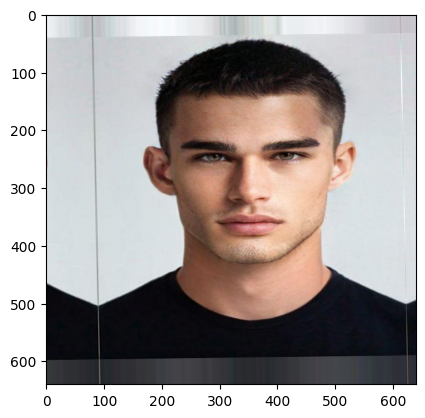

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

# Example of augmentation
sample_image = Image.open(train_images_path + "/__jpeg.rf.83725ed6bedc39d3a3cd85029caf91ef.jpg")
aug_iter = datagen.flow(np.array(sample_image).reshape((1, *sample_image.size, 3)))

plt.imshow(next(aug_iter)[0].astype('uint8'))
plt.show()
